<a href="https://colab.research.google.com/github/engineerJPark/EECS-498/blob/master/Assignment/A1/kNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EECS 498-007/598-005 Assignment 1-2: K-Nearest Neighbors (k-NN)

Before we start, please put your name and UMID in following format

: Firstname LASTNAME, #00000000   //   e.g.) Justin JOHNSON, #12345678

**Your Answer:**   
Hello WORLD, #XXXXXXXX

## K-Nearest Neighbors (k-NN)
In this notebook you will implement a K-Nearest Neighbors classifier on the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).

Recall that the K-Nearest Neighbor classifier does the following:
- During training, the classifier simply memorizes the training data
- During testing, test images are compared to each training image; the predicted label is the majority vote among the K nearest training examples.

After implementing the K-Nearest Neighbor classifier, you will use *cross-validation* to find the best value of K.

The goals of this exercise are to go through a simple example of the data-driven image classification pipeline, and also to practice writing efficient, vectorized code in [PyTorch](https://pytorch.org/).

## Install starter code
We have implemented some utility functions for this exercise in the [`coutils` package](https://github.com/deepvision-class/starter-code). Run this cell to download and install it.

이거 분석해서 스스로의 utility module을 만들자..


In [1]:
!pip install git+https://github.com/deepvision-class/starter-code

  Cloning https://github.com/deepvision-class/starter-code to /tmp/pip-req-build-a5gevb7w
  Running command git clone -q https://github.com/deepvision-class/starter-code /tmp/pip-req-build-a5gevb7w
  Created wheel for Colab-Utils: filename=Colab_Utils-0.1.dev0-py3-none-any.whl size=10306 sha256=b30ce4dbccc49d361d77641f5cc1352cada0f9351acf5adbe15212f044de83ba
  Stored in directory: /tmp/pip-ephem-wheel-cache-1q_0ec3z/wheels/eb/3c/88/465b0d78ef4a63d1f487c4208bd4691a448f05923eda0ef5f6
Successfully built Colab-Utils


## Setup code
Run some setup code for this notebook: Import some useful packages and increase the default figure size.

In [2]:
import coutils
import torch
import torchvision
import matplotlib.pyplot as plt
import statistics

#  increase the default figure size.
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['font.size'] = 16

## Load the CIFAR-10 dataset
The utility function `coutils.data.cifar10()` returns the entire CIFAR-10 dataset as a set of four **Torch tensors**:

- `x_train` contains all training images (real numbers in the range $[0, 1]$)
- `y_train` contains all training labels (integers in the range $[0, 9]$)
- `x_test` contains all test images
- `y_test` contains all test labels

This function automatically downloads the CIFAR-10 dataset the first time you run it.

In [3]:
x_train, y_train, x_test, y_test = coutils.data.cifar10()

print('Training set:', )
print('  data shape:', x_train.shape)
print('  labels shape: ', y_train.shape)
print('Test set:')
print('  data shape: ', x_test.shape)
print('  labels shape', y_test.shape)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to .
Training set:
  data shape: torch.Size([50000, 3, 32, 32])
  labels shape:  torch.Size([50000])
Test set:
  data shape:  torch.Size([10000, 3, 32, 32])
  labels shape torch.Size([10000])


## Visualize the dataset
To give you a sense of the nature of the images in CIFAR-10, this cell visualizes some random examples from the training set.

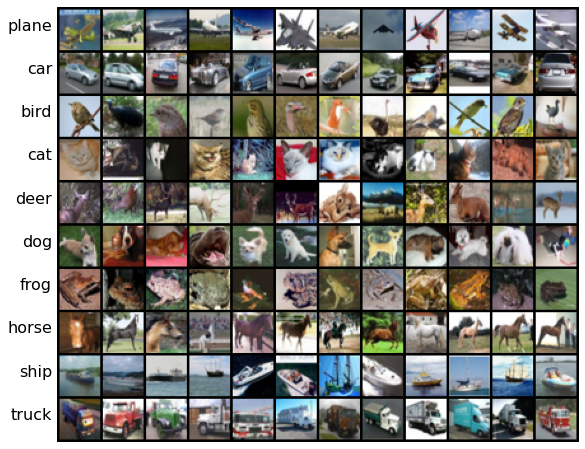

In [4]:
import random
from torchvision.utils import make_grid

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
samples_per_class = 12
samples = []
for y, cls in enumerate(classes):
  plt.text(-4, 34 * y + 18, cls, ha='right') # 글자 작성
  idxs = (y_train == y).nonzero().view(-1) # class가 같은 것의 idx 모음
  for i in range(samples_per_class):
    idx = idxs[random.randrange(idxs.shape[0])].item()
    samples.append(x_train[idx]) # sample 하나 랜덤하게 고른다. 이걸 12번 실행
img = torchvision.utils.make_grid(samples, nrow=samples_per_class) # 말그대로 sample로 grid를 만든다
plt.imshow(coutils.tensor_to_image(img)) # tensor를 이미지로 바꾼다.
plt.axis('off')
plt.show()

## Subsample the dataset
When implementing machine learning algorithms, it's usually a good idea to use a small sample of the full dataset. This way your code will run much faster, allowing for more interactive and efficient development. Once you are satisfied that you have correctly implemented the algorithm, you can then rerun with the entire dataset.

The function `coutils.data.cifar10()` can automatically subsample the CIFAR10 dataset for us. To see how to use it, we can check the documentation using the built-in `help` command:

---

`help()`명령을 이용해서 documentation을 볼 수 있다.

In [5]:
help(coutils.data.cifar10)

Help on function cifar10 in module coutils.data:

cifar10(num_train=None, num_test=None)
    Return the CIFAR10 dataset, automatically downloading it if necessary.
    This function can also subsample the dataset.
    
    Inputs:
    - num_train: [Optional] How many samples to keep from the training set.
      If not provided, then keep the entire training set.
    - num_test: [Optional] How many samples to keep from the test set.
      If not provided, then keep the entire test set.
    
    Returns:
    - x_train: float32 tensor of shape (num_train, 3, 32, 32)
    - y_train: int64 tensor of shape (num_train, 3, 32, 32)
    - x_test: float32 tensor of shape (num_test, 3, 32, 32)
    - y_test: int64 tensor of shape (num_test, 3, 32, 32)



We will subsample the data to use only 500 training examples and 100 test examples:

약간만 집어갈 것이므로 500, 100씩만 가져간다.

In [6]:
num_train = 500
num_test = 250

x_train, y_train, x_test, y_test = coutils.data.cifar10(num_train, num_test)

print('Training set:', )
print('  data shape:', x_train.shape)
print('  labels shape: ', y_train.shape)
print('Test set:')
print('  data shape: ', x_test.shape)
print('  labels shape', y_test.shape)

Training set:
  data shape: torch.Size([500, 3, 32, 32])
  labels shape:  torch.Size([500])
Test set:
  data shape:  torch.Size([250, 3, 32, 32])
  labels shape torch.Size([250])


## Compute distances: Naive implementation
Now that we have examined and prepared our data, it is time to implement the kNN classifier. We can break the process down into two steps:

1. Compute the (squared Euclidean) distances between all training examples and all test examples
2. Given these distances, for each test example find its k nearest neighbors and have them vote for the label to output

Lets begin with computing the distance matrix between all training and test examples. First we will implement a naive version of the distance computation, using explicit loops over the training and test sets:

**NOTE: When implementing distance functions in this notebook, you may not use the `torch.norm` function (or its instance method variant `x.norm`); you may not use any functions from `torch.nn` or `torch.nn.functional`.**

**이거 어떻게 하는 건지 모르겠다!**

잘못된 코드이다.
```
  # 각 이미지를 서로 비교하기 적절한 크기로 변경해야한다.
  x_train_flatten = x_train.reshape(num_train, x_train.shape[1], 1, -1)
  x_test_flatten = x_test.reshape(num_test, x_test.shape[1], 1, -1)
  # print(x_train_flatten.shape)
  # print(x_test_flatten.shape)
  norm_spatial = 0
  norm_channel = 0

  # 각 이미지 별로 행한다.
  for idx_train in range(num_train):
    for idx_test in range(num_test):
      for idx_channel in range(x_train_flatten.shape[1]):
        for idx_column in range(x_train_flatten.shape[3]):
          norm_spatial += (x_train_flatten[idx_train, idx_channel, 0, idx_column] - x_test_flatten[idx_test, idx_channel, 0, idx_column]) ** 2 # 완료되면 한 채널에 대한 norm이 나온다.
        norm_channel += norm_spatial
        norm_spatial = 0
        # print('Norm Channel : ', norm_channel)
      dists[idx_train, idx_test] = torch.sqrt(norm_channel)
      norm_channel = 0
      print('Dists : ', dists)
      print('Completed Row and Col : ', idx_train, ' ', idx_test)
  print('Result :', dists)
```

In [7]:
def compute_distances_two_loops(x_train, x_test):
  """
  Computes the squared Euclidean distance between each element of the training
  set and each element of the test set. Images should be flattened and treated
  as vectors.

  This implementation uses a naive set of nested loops over the training and
  test data.
  
  Inputs:
  - x_train: Torch tensor of shape (num_train, C, H, W)
  - x_test: Torch tensor of shape (num_test, C, H, W)

  Returns:
  - dists: Torch tensor of shape (num_train, num_test) where dists[i, j] is the
    squared Euclidean distance between the ith training point and the jth test
    point.
  """
  # Initialize dists to be a tensor of shape (num_train, num_test) with the
  # same datatype and device as x_train
  num_train = x_train.shape[0]
  num_test = x_test.shape[0]
  dists = x_train.new_zeros(num_train, num_test)
  ##############################################################################
  # TODO: Implement this function using a pair of nested loops over the        #
  # training data and the test data.                                           #
  #                                                                            #
  # You may not use torch.norm (or its instance method variant), nor any       #
  # functions from torch.nn or torch.nn.functional.                            #
  ##############################################################################
  # Replace "pass" statement with your code

  for i in range(num_train):
    for j in range(num_test):
      dists[i , j] = (x_train[i].reshape(-1) - x_test[j].reshape(-1)).pow(2).sum()
  ##############################################################################
  #                             END OF YOUR CODE                               #
  ##############################################################################
  return dists

After implementing the function above, we can run it to check that it has the expected shape:

In [8]:
num_train = 500
num_test = 250
x_train, y_train, x_test, y_test = coutils.data.cifar10(num_train, num_test)

dists = compute_distances_two_loops(x_train, x_test)
print('dists has shape: ', dists.shape)

dists has shape:  torch.Size([500, 250])


As a visual debugging step, we can visualize the distance matrix, where each row is a test example and each column is a training example.

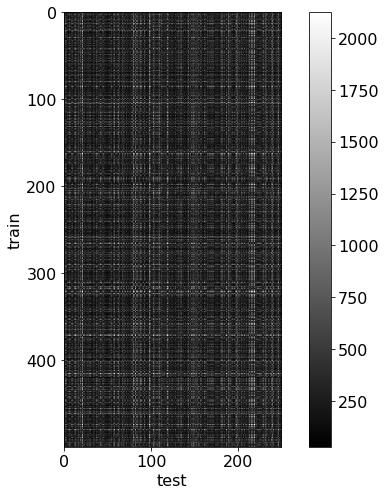

In [9]:
# 시각화
plt.imshow(dists.numpy(), cmap='gray', interpolation='none')
plt.colorbar()
plt.xlabel('test')
plt.ylabel('train')
plt.show()

## Compute distances: Vectorization
Our implementation of the distance computation above is fairly inefficient since it uses nested Python loops over the training and test sets.

When implementing algorithms in PyTorch, it's best to avoid loops in Python if possible. Instead it is preferable to implement your computation so that all loops happen inside PyTorch functions. This will usually be much faster than writing your own loops in Python, since PyTorch functions can be internally optimized to iterate efficiently, possibly using multiple threads. This is especially important when using a GPU to accelerate your code.

The process of eliminating explict loops from your code is called **vectorization**. Sometimes it is straighforward to vectorize code originally written with loops; other times vectorizing requires thinking about the problem in a new way. We will use vectorization to improve the speed of our distance computation function.

As a first step toward vectorizing our distance computation, complete the following implementation which uses only a single Python loop over the training data:

---

code 사용할 때 Python의 loop를 이용하지 말라. 그냥 PyTorch에서 제공하는 함수를 사용해라.

이렇게 loop를 없애는 과정을 **vectorization**이라고 한다. 이걸 하면 속도가 향상된다고 한다.

아래는 단 하나의 loop으로 위의 문제를 해결하는 것이다.

**이거 어떻게 하는 건지 모르겠다**

잘못된 코드
```
  # 각 이미지를 서로 비교하기 적절한 크기로 변경해야한다.
  x_train_flatten = x_train.reshape(num_train, x_train.shape[1], 1, -1)
  x_test_flatten = x_test.reshape(num_test, x_test.shape[1], 1, -1)  

  for idx_train in range(num_train):
    for idx_test in range(num_test):
      norm = torch.sqrt(((x_train_flatten[idx_train] - x_test_flatten[idx_test]) ** 2).sum())
      dists[idx_train, idx_test] = norm
      print('Dists : ', dists)
      print('Completed Row and Col : ', idx_train, ' ', idx_test)
  print('Result :', dists)
```

In [10]:
# 이렇게 broad casting 되는 것을 알 수 있다.
# dimension이 없는 부분에 dimension 1으로 생성해주고 그 곳을 기준으로 확장

x = torch.tensor([
                  [[1,2,3,4],
                  [5,6,7,8],
                  [9,10,11,12]],
                  [[1,2,3,4],
                  [5,6,7,8],
                  [9,10,11,12]]
])
y = torch.tensor([
                  [[1,2,3,4],
                  [5,6,7,8],
                  [9,10,11,12]],
                  [[0,0,0,0],
                  [0,0,0,0],
                  [0,0,0,0]]
])

print(x - y[0])
print(x - y[1])

tensor([[[0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]],

        [[0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]]])
tensor([[[ 1,  2,  3,  4],
         [ 5,  6,  7,  8],
         [ 9, 10, 11, 12]],

        [[ 1,  2,  3,  4],
         [ 5,  6,  7,  8],
         [ 9, 10, 11, 12]]])


In [11]:
def compute_distances_one_loop(x_train, x_test):
  """
  Computes the squared Euclidean distance between each element of the training
  set and each element of the test set. Images should be flattened and treated
  as vectors.

  This implementation uses only a single loop over the training data.

  Inputs:
  - x_train: Torch tensor of shape (num_train, C, H, W)
  - x_test: Torch tensor of shape (num_test, C, H, W)

  Returns:
  - dists: Torch tensor of shape (num_train, num_test) where dists[i, j] is the
    squared Euclidean distance between the ith training point and the jth test
    point.
  """
  # Initialize dists to be a tensor of shape (num_train, num_test) with the
  # same datatype and device as x_train
  num_train = x_train.shape[0]
  num_test = x_test.shape[0]
  dists = x_train.new_zeros(num_train, num_test)
  ##############################################################################
  # TODO: Implement this function using only a single loop over x_train.       #
  #                                                                            #
  # You may not use torch.norm (or its instance method variant), nor any       #
  # functions from torch.nn or torch.nn.functional.                            #
  ##############################################################################
  # Replace "pass" statement with your code

  x_test=x_test.view(num_test,-1)
  x_train=x_train.view(num_train,-1)

  for i in range(num_train):
    dists[i]= (x_test - x_train[i]).pow(2).sum(dim=1)
  
  ##############################################################################
  #                             END OF YOUR CODE                               #
  ##############################################################################
  return dists

We can check the correctness of our one-loop implementation by comparing it with our two-loop implementation on some randomly generated data.

Note that we do the comparison with 64-bit floating points for increased numeric precision.

In [12]:
torch.manual_seed(0)
x_train_rand = torch.randn(100, 3, 16, 16, dtype=torch.float64)
x_test_rand = torch.randn(100, 3, 16, 16, dtype=torch.float64)

dists_one = compute_distances_one_loop(x_train_rand, x_test_rand)
dists_two = compute_distances_two_loops(x_train_rand, x_test_rand)
difference = (dists_one - dists_two).pow(2).sum().sqrt().item()
print('Difference: ', difference)
if difference < 1e-4:
  print('Good! The distance matrices match')
else:
  print('Uh-oh! The distance matrices are different')

Difference:  0.0
Good! The distance matrices match


Now implement a fully vectorized version of the distance computation function
that does not use any python loops.

```
  for idx_train in range(num_train):
    for idx_test in range(num_test):
      norm = (x_train[idx_train] - x_test[idx_test]).pow(2).sum().sqrt()
      dists[idx_train, idx_test] = norm
```

In [13]:
def compute_distances_no_loops(x_train, x_test):
  """
  Computes the squared Euclidean distance between each element of the training
  set and each element of the test set. Images should be flattened and treated
  as vectors.

  This implementation should not use any Python loops. For memory-efficiency,
  it also should not create any large intermediate tensors; in particular you
  should not create any intermediate tensors with O(num_train*num_test)
  elements.

  Inputs:
  - x_train: Torch tensor of shape (num_train, C, H, W)
  - x_test: Torch tensor of shape (num_test, C, H, W)

  Returns:
  - dists: Torch tensor of shape (num_train, num_test) where dists[i, j] is the
    squared Euclidean distance between the ith training point and the jth test
    point.
  """
  # Initialize dists to be a tensor of shape (num_train, num_test) with the
  # same datatype and device as x_train
  num_train = x_train.shape[0]
  num_test = x_test.shape[0]
  dists = x_train.new_zeros(num_train, num_test)
  ##############################################################################
  # TODO: Implement this function without using any explicit loops and without #
  # creating any intermediate tensors with O(num_train * num_test) elements.   #
  #                                                                            #
  # You may not use torch.norm (or its instance method variant), nor any       #
  # functions from torch.nn or torch.nn.functional.                            #
  #                                                                            #
  # HINT: Try to formulate the Euclidean distance using two broadcast sums     #
  #       and a matrix multiply.                                               #
  ##############################################################################
  # Replace "pass" statement with your code

  x_test = x_test.view(num_test,-1)
  x_train = x_train.view(num_train,-1)

  # print(torch.sum(x_train**2,dim=1).view(-1,1).shape)
  # print(torch.mm(x_train, x_test.t()).shape)
  

  dists = torch.sum(x_train**2,dim=1).view(-1,1) + torch.sum(x_test**2,dim=1).view(1,-1) - 2*torch.mm(x_train,x_test.t()) # 곱셈 공식 적용. 다른 방법은 차원이 맞을 수가 없어서..
  # print(dists.shape)
  ##############################################################################
  #                             END OF YOUR CODE                               #
  ##############################################################################
  return dists

As before, we can check the correctness of our implementation by comparing the fully vectorized version against the original naive version:

In [14]:
torch.manual_seed(0)
x_train_rand = torch.randn(100, 3, 16, 16, dtype=torch.float64)
x_test_rand = torch.randn(100, 3, 16, 16, dtype=torch.float64)

dists_two = compute_distances_two_loops(x_train_rand, x_test_rand)
dists_none = compute_distances_no_loops(x_train_rand, x_test_rand)
difference = (dists_two - dists_none).pow(2).sum().sqrt().item()
print('Difference: ', difference)
if difference < 1e-4:
  print('Good! The distance matrices match')
else:
  print('Uh-oh! The distance matrices are different')

Difference:  1.8902124902629952e-11
Good! The distance matrices match


We can now compare the speed of our three implementations. If you've implemented everything properly, the one-loop implementation should take less than 4 seconds to run, and the fully vectorized implementation should take less than 0.1 seconds to run.

In [15]:
# 속도 비교
import time

def timeit(f, *args):
  tic = time.time()
  f(*args) 
  toc = time.time()
  return toc - tic

torch.manual_seed(0)
x_train_rand = torch.randn(500, 3, 32, 32)
x_test_rand = torch.randn(500, 3, 32, 32)

two_loop_time = timeit(compute_distances_two_loops, x_train_rand, x_test_rand)
print('Two loop version took %.2f seconds' % two_loop_time)

one_loop_time = timeit(compute_distances_one_loop, x_train_rand, x_test_rand)
speedup = two_loop_time / one_loop_time
print('One loop version took %.2f seconds (%.1fX speedup)'
      % (one_loop_time, speedup))

no_loop_time = timeit(compute_distances_no_loops, x_train_rand, x_test_rand)
speedup = two_loop_time / no_loop_time
print('No loop version took %.2f seconds (%.1fX speedup)'
      % (no_loop_time, speedup))

Two loop version took 13.78 seconds
One loop version took 2.86 seconds (4.8X speedup)
No loop version took 0.06 seconds (213.5X speedup)


## Predict labels
Now that we have a method for computing distances between training and test examples, we need to implement a function that uses those distances together with the training labels to predict labels for test samples.

Complete the implementation of the function below:

In [16]:
def predict_labels(dists, y_train, k=1):
  """
  Given distances between all pairs of training and test samples, predict a
  label for each test sample by taking a majority vote among its k nearest
  neighbors in the training set.
 
  In the event of a tie, this function should return the smaller label. For
  example, if k=5 and the 5 nearest neighbors to a test example have labels
  [1, 2, 1, 2, 3] then there is a tie between 1 and 2 (each have 2 votes), so
  we should return 1 since it is the smaller label.

  같은 개수 나오면 smaller label을 고르라는 뜻이다.

  Inputs:
  - dists: Torch tensor of shape (num_train, num_test) where dists[i, j] is the
    squared Euclidean distance between the ith training point and the jth test
    point.
  - y_train: Torch tensor of shape (y_train,) giving labels for all training
    samples. Each label is an integer in the range [0, num_classes - 1]
  - k: The number of nearest neighbors to use for classification.

  Returns:
  - y_pred: A torch int64 tensor of shape (num_test,) giving predicted labels
    for the test data, where y_pred[j] is the predicted label for the jth test
    example. Each label should be an integer in the range [0, num_classes - 1].
  """
  num_train, num_test = dists.shape
  y_pred = torch.zeros(num_test, dtype=torch.int64)
  ##############################################################################
  # TODO: Implement this function. You may use an explicit loop over the test  #
  # samples. Hint: Look up the function torch.topk                             #
  ##############################################################################
  # Replace "pass" statement with your code
  # dists에서 하나의 row는 해당 train image가 각 test image에 대해서 얼마나 가까운지를 나타낸 것이다.

  # 주의!!!
  for idx_test in range(num_test):
    values, index = torch.topk(dists[:, idx_test], k, largest=False) # 하나의 test data에 대한 train data의 최소값 k개 가져오기
    labels = y_train[index]
    modevalues, modeindex = torch.mode(y_train[index]) # 해당 train data에 대한 최빈값 및 그 index
    y_pred[idx_test] = modevalues
    
    # # 최소 label을 어떻게 구할 것인가
    # count = (labels == modevalues).sum()
    # del(labels[modevalues == labels])

    # modevalues2, modeindex2 = torch.mode(labels) # 해당 train data에 대한 최빈값 및 그 index
    # count2 = (labels == modevalues2).sum()

    # if count == count2:
    #   y_pred[idx_test] = modevalues if modevalues < modevalues2 else modevalues2
  ##############################################################################
  #                             END OF YOUR CODE                               #
  ##############################################################################
  return y_pred

Now we have implemented all the required functionality for the K-Nearest Neighbor classifier. We can define a simple object to encapsulate the classifier:

위와 같이 함수를 모두 만들고, Class로 묶는 습관을 만들자.

참고로 여기서는 외부에서 함수를 선언하고 Class로 묶었지만, 경우에 따라서는 Class의 method로 선언하고 묶는 것이 나을 수도 있다.

In [17]:
class KnnClassifier:
  def __init__(self, x_train, y_train):
    """
    Create a new K-Nearest Neighbor classifier with the specified training data.
    In the initializer we simply memorize the provided training data.

    Inputs:
    - x_train: Torch tensor of shape (num_train, C, H, W) giving training data
    - y_train: int64 torch tensor of shape (num_train,) giving training labels
    """
    self.x_train = x_train.contiguous() # Tensor의 memory format을 변경한다.
    self.y_train = y_train.contiguous()
  
  def predict(self, x_test, k=1):
    """
    Make predictions using the classifier.
   
    Inputs:
    - x_test: Torch tensor of shape (num_test, C, H, W) giving test samples
    - k: The number of neighbors to use for predictions
  
    Returns:
    - y_test_pred: Torch tensor of shape (num_test,) giving predicted labels
      for the test samples.
    """
    dists = compute_distances_no_loops(self.x_train, x_test.contiguous())
    y_test_pred = predict_labels(dists, self.y_train, k=k)
    return y_test_pred
  
  def check_accuracy(self, x_test, y_test, k=1, quiet=False):
    """
    Utility method for checking the accuracy of this classifier on test data.
    Returns the accuracy of the classifier on the test data, and also prints a
    message giving the accuracy.

    Inputs:
    - x_test: Torch tensor of shape (num_test, C, H, W) giving test samples
    - y_test: int64 torch tensor of shape (num_test,) giving test labels
    - k: The number of neighbors to use for prediction
    - quiet: If True, don't print a message.
  
    Returns:
    - accuracy: Accuracy of this classifier on the test data, as a percent.
      Python float in the range [0, 100]
    """
    y_test_pred = self.predict(x_test, k=k)
    num_samples = x_test.shape[0] # 모든 이미지의 개수가 나올 것이다.
    num_correct = (y_test == y_test_pred).sum().item() # 1을 총합한다. int가 결과로 나올 것이다.
    accuracy = 100.0 * num_correct / num_samples
    msg = (f'Got {num_correct} / {num_samples} correct; '
           f'accuracy is {accuracy:.2f}%')
    if not quiet:
      print(msg)
    return accuracy

Now lets put everything together and test our K-NN clasifier on a subset of CIFAR-10, using k=1:

If you've implemented everything correctly you should see an accuracy of about 27%.

In [18]:
num_train = 5000
num_test = 500
x_train, y_train, x_test, y_test = coutils.data.cifar10(num_train, num_test)

classifier = KnnClassifier(x_train, y_train)
classifier.check_accuracy(x_test, y_test, k=1)

Got 137 / 500 correct; accuracy is 27.40%


27.4

Now lets increase to k=5. You should see a slightly higher accuracy than k=1:

하하 참 높다 야

In [19]:
classifier.check_accuracy(x_test, y_test, k=5)

Got 139 / 500 correct; accuracy is 27.80%


27.8

## Cross-validation
We have not implemented the full k-Nearest Neighbor classifier, but the choice of $k=5$ was arbitrary. We will use **cross-validation** to set this hyperparameter in a more principled manner.

Implement the following function to run cross-validation:

In [27]:
def knn_cross_validate(x_train, y_train, num_folds=5, k_choices=None):
  """
  Perform cross-validation for KnnClassifier.

  Inputs:
  - x_train: Tensor of shape (num_train, C, H, W) giving all training data
  - y_train: int64 tensor of shape (num_train,) giving labels for training data
  - num_folds: Integer giving the number of folds to use
  - k_choices: List of integers giving the values of k to try
 
  Returns:
  - k_to_accuracies: Dictionary mapping values of k to lists, where
    k_to_accuracies[k][i] is the accuracy on the ith fold of a KnnClassifier
    that uses k nearest neighbors.
  """
  if k_choices is None:
    # Use default values
    k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

  # First we divide the training data into num_folds equally-sized folds.
  x_train_folds = []
  y_train_folds = []
  ##############################################################################
  # TODO: Split the training data and images into folds. After splitting,      #
  # x_train_folds and y_train_folds should be lists of length num_folds, where #
  # y_train_folds[i] is the label vector for images in x_train_folds[i].       #
  # Hint: torch.chunk                                                          #
  ##############################################################################
  # Replace "pass" statement with your code
  x_train_folds = torch.chunk(x_train, num_folds)
  y_train_folds = torch.chunk(y_train, num_folds)
  ##############################################################################
  #                            END OF YOUR CODE                                #
  ##############################################################################
  
  # A dictionary holding the accuracies for different values of k that we find
  # when running cross-validation. After running cross-validation,
  # k_to_accuracies[k] should be a list of length num_folds giving the different
  # accuracies we found when trying KnnClassifiers that use k neighbors.

  # 각 k마다의 accuracy를 보관
  # value는 길이가 num_fold인 리스트. 그 리스트의 내용물은 각 fold의 accuracy.
  k_to_accuracies = {}

  ##############################################################################
  # TODO: Perform cross-validation to find the best value of k. For each value #
  # of k in k_choices, run the k-nearest-neighbor algorithm num_folds times;   #
  # in each case you'll use all but one fold as training data, and use the     #
  # last fold as a validation set. Store the accuracies for all folds and all  #
  # values in k in k_to_accuracies.   HINT: torch.cat                          #
  ##############################################################################
  # Replace "pass" statement with your code
  # kNN을 num_folds만큼 돌리고, 마지막 fold는 validation으로 써라
  # k_to_accuracies에 정확도 기록하구.

  x_validation = x_train_folds[num_folds - 1]
  y_validation = y_train_folds[num_folds - 1]

  # predicting and validating
  accuracy_list = []
  for idx_k in k_choices:
    for idx_fold in range(num_folds - 1):
      classifier = KnnClassifier(x_train_folds[idx_fold], y_train_folds[idx_fold])
      accuracy_list.append(classifier.check_accuracy(x_validation, y_validation, k=idx_k))
    k_to_accuracies[idx_k] = accuracy_list
    accuracy_list = []
  ##############################################################################
  #                            END OF YOUR CODE                                #
  ##############################################################################

  return k_to_accuracies

Now we'll run your cross-validation function:

In [28]:
num_train = 5000
num_test = 500
x_train, y_train, x_test, y_test = coutils.data.cifar10(num_train, num_test)

k_to_accuracies = knn_cross_validate(x_train, y_train, num_folds=5)

for k, accs in sorted(k_to_accuracies.items()):
  print('k = %d got accuracies: %r' % (k, accs))

Got 245 / 1000 correct; accuracy is 24.50%
Got 232 / 1000 correct; accuracy is 23.20%
Got 259 / 1000 correct; accuracy is 25.90%
Got 227 / 1000 correct; accuracy is 22.70%
Got 247 / 1000 correct; accuracy is 24.70%
Got 250 / 1000 correct; accuracy is 25.00%
Got 237 / 1000 correct; accuracy is 23.70%
Got 214 / 1000 correct; accuracy is 21.40%
Got 252 / 1000 correct; accuracy is 25.20%
Got 247 / 1000 correct; accuracy is 24.70%
Got 247 / 1000 correct; accuracy is 24.70%
Got 239 / 1000 correct; accuracy is 23.90%
Got 256 / 1000 correct; accuracy is 25.60%
Got 248 / 1000 correct; accuracy is 24.80%
Got 266 / 1000 correct; accuracy is 26.60%
Got 232 / 1000 correct; accuracy is 23.20%
Got 260 / 1000 correct; accuracy is 26.00%
Got 250 / 1000 correct; accuracy is 25.00%
Got 254 / 1000 correct; accuracy is 25.40%
Got 232 / 1000 correct; accuracy is 23.20%
Got 263 / 1000 correct; accuracy is 26.30%
Got 242 / 1000 correct; accuracy is 24.20%
Got 258 / 1000 correct; accuracy is 25.80%
Got 246 / 1

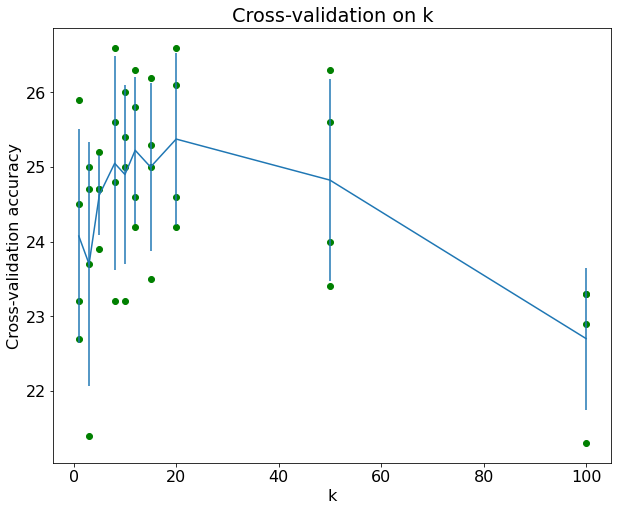

In [29]:
# plotting
ks, means, stds = [], [], []
for k, accs in sorted(k_to_accuracies.items()):
  plt.scatter([k] * len(accs), accs, color='g')
  ks.append(k)
  means.append(statistics.mean(accs))
  stds.append(statistics.stdev(accs))
plt.errorbar(ks, means, yerr=stds)
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.title('Cross-validation on k')
plt.show()

Now we can use the results of cross-validation to select the best value for k, and rerun the classifier on our full 5000 set of training examples.

You should get an accuracy above 28%.

In [40]:
acc_list = list(k_to_accuracies.values())[2]

sum(acc_list) / len(acc_list)

24.625

In [48]:
best_k = 1
##############################################################################
# TODO: Use the results of cross-validation stored in k_to_accuracies to     #
# choose the value of k, and store the result in best_k. You should choose   #
# the value of k that has the highest mean accuracy accross all folds.       #
##############################################################################
# Replace "pass" statement with your code
k_list = []
for acc_list in list(k_to_accuracies.values()):
  k_list.append(sum(acc_list) / len(acc_list))
# argmax and best k. use list.index
idx_k_list = k_list.index(max(k_list))
best_k = list(k_to_accuracies.keys())[idx_k_list]
##############################################################################
#                            END OF YOUR CODE                                #
##############################################################################
    
print('Best k is ', best_k)
classifier = KnnClassifier(x_train, y_train)
classifier.check_accuracy(x_test, y_test, k=best_k)

Best k is  20
Got 136 / 500 correct; accuracy is 27.20%


27.2

Finally, we can use our chosen value of k to run on the entire training and test sets.

This may take a while to run, since the full training and test sets have 50k and 10k examples respectively. You should get an accuracy above 33%.

**Run this only once!**

In [49]:
x_train_all, y_train_all, x_test_all, y_test_all = coutils.data.cifar10()
classifier = KnnClassifier(x_train_all, y_train_all)
classifier.check_accuracy(x_test_all, y_test_all, k=best_k)

Got 3375 / 10000 correct; accuracy is 33.75%


33.75